In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from caveclient import CAVEclient

In [217]:
bin_width = 0.05
step_size = 0.005
y_resolution = 4  # nm per voxel

In [3]:
labels = np.array([107000, 147000, 184000, 224000, 265000]) * y_resolution / 1_000_000  # manual labels

# Gather data

In [7]:
datastack_name = "minnie65_phase3_v1"
client = CAVEclient(datastack_name)

In [8]:
nuclei = client.materialize.query_table("nucleus_detection_v0")

In [9]:
all_cells = client.materialize.query_table("allen_soma_coarse_cell_class_model_v1")
all_cells["num_soma"] = all_cells.groupby("pt_root_id").transform("count")["valid"]
cells_by_root = all_cells.copy()
cells_by_root.index = cells_by_root.pt_root_id

In [10]:
valid_ids = set(all_cells.query("num_soma == 1").pt_root_id)

In [11]:
soma_features = pd.read_pickle("Minnie_soma_nuc_feature_model_83_1.pkl")

nuc_to_root = client.materialize.query_table("nucleus_neuron_svm")

nuc_to_root.index = nuc_to_root.id

soma_features["seg_id"] = [nuc_to_root.loc[n].pt_root_id for n in soma_features.nuc_id]
soma_features.index = soma_features.seg_id
soma_features.columns  
# size is equal to nucleus volume
# soma area and nucleus area closely track their respective volumes
# avg sdf is a list of the 'diameters' of processes (e.g. dendrites) that leave each cell body

Index(['index', 'nucleus_area', 'nucleus_area_to_volume',
       'nucleus_center_mass_nm', 'nucleus_fold_area', 'nucleus_fract_fold',
       'nucleus_id', 'nucleus_volume', 'cleft_segid', 'size', 'centroid_x',
       'centroid_y', 'centroid_z', 'yr_um_translated', 'predict',
       'is_watertight', 'soma_center_mass', 'soma_volume', 'soma_area',
       'soma_area_to_volume', 'num_processes', 'avg_sdf', 'orients', 'vectors',
       'n_soma_syn', 'soma_syn_density', 'nuc_id', 'seg_id', 'soma_y',
       'soma_x', 'soma_z', 'xr', 'yr', 'nucleus_to_soma', 'sum_proc_sdf',
       'cell_type_pred_num', 'cell_type_pred', 'umapx', 'umapy', 'visible',
       'outline_color', 'outline_width', 'max_sdf'],
      dtype='object')

In [12]:
soma_features_root_ids = set(soma_features.seg_id)

In [13]:
col_cells = client.materialize.query_table("allen_v1_column_types_v2", split_positions=False)

In [14]:
exc_cells = col_cells.query("classification_system == 'aibs_coarse_excitatory'")
inh_cells = col_cells.query("classification_system == 'aibs_coarse_inhibitory'")
len(exc_cells), len(inh_cells)

(1185, 162)

In [424]:
features = ["soma_volume"] #, "n_soma_syn", "nucleus_volume", "nucleus_fract_fold", "sum_proc_sdf"]

In [382]:
auto_cells = client.materialize.query_table("allen_soma_coarse_cell_class_model_v1")

# bounding box of the proofread column we're interested in
bbox = np.array([[ 672444., 200000., 805320.], [ 772444., 1294000., 905320.]])  # nm
resolution = np.array([4., 4., 40.])
bbox /= resolution
def in_bbox(p):
    """ returns whether point is between the two points given by bbox"""
    lower, upper = bbox
    return lower[0] <= p[0] < upper[0] and lower[1] <= p[1] < upper[1] and lower[2] <= p[2] < upper[2]

auto_col_cells = auto_cells[auto_cells.pt_position.apply(in_bbox)]
# add soma features columns to auto_col_cells
for feature in features:
    auto_col_cells[feature] = [(soma_features.loc[r][feature] if r in soma_features_root_ids and type(soma_features.loc[r][feature]) is not pd.Series else np.nan)
                           for r in auto_col_cells.pt_root_id]
auto_exc_cells = auto_col_cells.query("classification_system == 'aibs_coarse_excitatory'")
auto_inh_cells = auto_col_cells.query("classification_system == 'aibs_coarse_inhibitory'")

C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

## Synapses in the center of the column

In [444]:
syn_bbox = bbox.copy()
sample_width = 10_000  # nm square cross section
x_vx_width = sample_width / resolution[0]
z_vx_width = sample_width / resolution[2]
syn_bbox[0, 0] = bbox[0, 0] + (bbox[1, 0] - bbox[0, 0]) / 2
syn_bbox[1, 0] = syn_bbox[0, 0] + x_vx_width
syn_bbox[0, 2] = bbox[0, 2] + (bbox[1, 2] - bbox[0, 2]) / 2
syn_bbox[1, 2] = syn_bbox[0, 2] + z_vx_width
syn_bbox, bbox

(array([[180611.,  50000.,  21383.],
        [183111., 323500.,  21633.]]),
 array([[168111.,  50000.,  20133.],
        [193111., 323500.,  22633.]]))

In [445]:
synapses = client.materialize.synapse_query(bounding_box=syn_bbox, bounding_box_column="ctr_pt_position", split_positions=True)

In [446]:
synapses["pre_type"] = [(cells_by_root.loc[root].cell_type if root in valid_ids else "N/A") for root in synapses.pre_pt_root_id]
synapses["post_type"] = [(cells_by_root.loc[root].cell_type if root in valid_ids else "N/A") for root in synapses.post_pt_root_id]
syn_depths = synapses.ctr_pt_position_y.values * y_resolution / 1_000_000
syn_depths_by_pre = dict((t, []) for t in cell_types)
syn_depths_by_post = dict((t, []) for t in cell_types)
for i in synapses.index:
    # pre
    syn = synapses.loc[i]
    if syn.pre_type in ctype_to_layer.keys():
        syn_depths_by_pre["exc"].append(syn.ctr_pt_position_y * y_resolution / 1_000_000)
    elif syn.pre_type in syn_depths_by_pre.keys():
        syn_depths_by_pre[syn.pre_type].append(syn.ctr_pt_position_y * y_resolution / 1_000_000)
    
    # post
    if syn.post_type in ctype_to_layer.keys():
        syn_depths_by_post["exc"].append(syn.ctr_pt_position_y * y_resolution / 1_000_000)
    elif syn.post_type in syn_depths_by_post.keys():
        syn_depths_by_post[syn.post_type].append(syn.ctr_pt_position_y * y_resolution / 1_000_000)
for t in syn_depths_by_pre:
    syn_depths_by_pre[t] = np.array(syn_depths_by_pre[t])
for t in syn_depths_by_post:
    syn_depths_by_post[t] = np.array(syn_depths_by_post[t])

synapses

,id,valid,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_position_x,post_pt_position_y,post_pt_position_z,post_pt_supervoxel_id,post_pt_root_id,ctr_pt_position_x,ctr_pt_position_y,ctr_pt_position_z,size,pre_type,post_type
0,165543171,t,182532,162148,21401,89874493577062805,864691135406145778,182502,162178,21409,89874493577078337,864691136602049489,182514,162176,21406,3048,N/A,MC
1,168640659,t,182066,205398,21608,89809897335697882,864691134554732752,181954,205386,21608,89809897335699907,864691136194449740,182006,205366,21614,3036,N/A,5P_IT
2,166909980,t,182480,172396,21469,89875867966672084,864691135373530824,182458,172306,21473,89875867966673020,864691135354901711,182514,172320,21476,19024,N/A,4P
3,165039980,t,182186,134386,21627,89800414047943105,864691135507506884,182136,134334,21636,89800345328466671,864691135771743563,182171,134354,21627,9744,N/A,BC
4,166843764,t,182448,169688,21406,89875524369248710,864691135489538756,182516,169658,21408,89875455649809129,864691135753571277,182490,169652,21406,3052,N/A,4P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54133,165092240,t,182286,87050,21431,89794023069395484,864691134974174632,182276,86932,21425,89794023069392698,864691133617329487,182278,87002,21431,204,N/A,N/A
54134,165628644,t,182960,125948,21574,89939983305122289,864691136617397211,182866,125894,21571,89939983305119255,864691133599719048,182922,125880,21573,2288,N/A,N/A
54135,169879523,t,182732,246282,21631,89885763638045264,864691135162274349,182632,246276,21628,89885763638040698,864691135602850244,182702,246248,21632,3036,BPC,N/A
54136,170162076,t,182254,240632,21384,89814638912801480,864691135485446130,182324,240626,21395,89885007656944904,864691135730428857,182284,240616,21388,268,N/A,N/A


In [447]:
cell_types = ["exc", "BC", "BPC", "MC", "NGC"]
ctype_to_layer = {"23P": "23",
                 "4P": "4",
                 "5P_PT": "5",
                 "5P_IT": "5",
                 "5P_NP": "5",
                 "6P": "6",
                 "6CT": "6",
                 "6IT": "6"}

In [425]:
# cross sectional area to be layered
xarea = resolution[0] * resolution[2] * (bbox[1][0] - bbox[0][0]) * (bbox[1][2] - bbox[0][2]) / 1_000_000 ** 2

In [426]:
# min is pia border (with L1) and max is white matter border (with L6)
min_y = min(pt[1] * y_resolution / 1_000_000 for pt in auto_col_cells.pt_position)
max_y = max(pt[1] * y_resolution / 1_000_000 for pt in auto_col_cells.pt_position)
min_y, max_y

(0.358016, 1.086656)

### Sort the dataframe of cells by depth to make getting features by depth way faster

In [427]:
auto_col_cells = auto_col_cells.sort_values(axis="index", by="pt_position", key=lambda xs: pd.Series([x[1] for x in xs]))

def get_cutoff_idx(df, y, prev_cutoff_idx, position_col="pt_position"):
    """efficiently find the first index after prev_cutoff_idx where position[1] is greater than y"""
    i = prev_cutoff_idx
    if i >= len(df):
        return i
    while df.iloc[i][position_col][1] * y_resolution / 1_000_000 < y:
        i += 1
        if i >= len(df):
            return i
    return i  # new_cutoff_idx

In [428]:
exc_soma_densities = []
inh_soma_densities = []
synapse_densities = []
# syn_densities_by_pre = dict((t, []) for t in syn_depths_by_pre.keys())
# syn_densities_by_post = dict((t, []) for t in syn_depths_by_post.keys())
p_type = dict((t, []) for t in ["23", "4", "5", "6"])
p_inh_subclass = dict((t, []) for t in ["BC", "BPC", "MC", "NGC"])
exc_soma_features_by_depth = dict((f, []) for f in features)
inh_soma_features_by_depth = dict((f, []) for f in features)
soma_features_by_depth = dict((f, []) for f in features)
bin_centers = []

curr_y = min_y
prev_cutoff_idx = 0
while curr_y < max_y:
    bin_centers.append(curr_y + bin_width // 2)
    # first index where pt_position[1] is greater than curr_y + bin_width 
    cutoff_idx = get_cutoff_idx(auto_col_cells, curr_y + bin_width, prev_cutoff_idx)
    lower_cutoff_idx = get_cutoff_idx(auto_col_cells, curr_y, prev_cutoff_idx)
    
    current_cells = auto_col_cells.iloc[lower_cutoff_idx:cutoff_idx]
    current_exc_cells = current_cells.query("classification_system == 'aibs_coarse_excitatory'")
    current_inh_cells = current_cells.query("classification_system == 'aibs_coarse_inhibitory'")
    
    for f in features:
        soma_features_by_depth[f].append(current_cells[f].mean())
        exc_soma_features_by_depth[f].append(current_exc_cells[f].mean())
        inh_soma_features_by_depth[f].append(current_inh_cells[f].mean())
                          
    for t in p_type:
        p_type[t].append(0)
    for i in current_exc_cells.index:
        if current_exc_cells.loc[i].cell_type != "Unsure":
            p_type[ctype_to_layer[current_exc_cells.loc[i].cell_type]][-1] += 1 / len(current_exc_cells) if len(current_exc_cells) > 0 else np.nan
    exc_soma_densities.append(len(current_exc_cells))
    
    inh_soma_densities.append(len(current_inh_cells))
    for t in p_inh_subclass:
        p_inh_subclass[t].append(0)
    for i in current_inh_cells.index:
        if current_inh_cells.loc[i].cell_type != "Unsure":
            p_inh_subclass[current_inh_cells.loc[i].cell_type][-1] += 1 / len(current_inh_cells) if len(current_inh_cells) > 0 else np.nan
            
    # # this is still slow
    # synapse_densities.append(sum((curr_y <= syn_depths) & (syn_depths < curr_y + bin_width)))
    # for t in syn_densities_by_pre.keys():
    #     syn_densities_by_pre[t].append(sum((curr_y <= syn_depths_by_pre[t]) & (syn_depths_by_pre[t] < curr_y + bin_width)))
    # for t in syn_densities_by_post.keys():
    #     syn_densities_by_post[t].append(sum((curr_y <= syn_depths_by_post[t]) & (syn_depths_by_post[t] < curr_y + bin_width)))
    
    curr_y += step_size
    prev_cutoff_idx = lower_cutoff_idx
bin_centers = np.array(bin_centers)
exc_soma_densities = np.array(exc_soma_densities, dtype=float) / (bin_width * xarea)  # per mm^3
inh_soma_densities = np.array(inh_soma_densities, dtype=float) / (bin_width * xarea)
# synapse_densities = np.array(synapse_densities, dtype=float) / (bin_width * xarea)
for t in p_type:
    p_type[t] = np.array(p_type[t])
for t in p_inh_subclass:
    p_inh_subclass[t] = np.array(p_inh_subclass[t])
# for t in syn_densities_by_pre:
#     syn_densities_by_pre[t] = np.array(syn_densities_by_pre[t]) / (bin_width * xarea)
# for t in syn_depths_by_post:
#     syn_densities_by_post[t] = np.array(syn_densities_by_post[t]) / (bin_width * xarea)

L1: low soma density
L2: high soma density
L3: med soma density
L4: high soma density
L5: med soma density, large soma
L6: medhigh soma density

L1-L2	107000

L3-L4	147000
L4-L5	184000
L5-L6	224000
L6-WM	265000

## Plot!

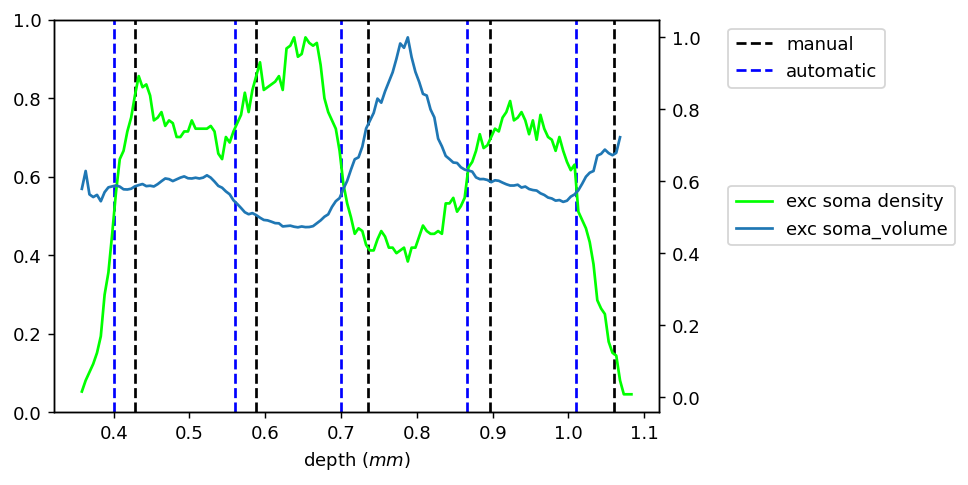

In [442]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=130)
ax2 = ax.twinx()
# ax.plot(bin_centers, inh_soma_densities, c="indigo", label="inh soma density")
ax2.plot(bin_centers, exc_soma_densities / np.nanmax(exc_soma_densities), c="lime", label="exc soma density")
# ax2.plot(bin_centers, normalized_smooth_exc_densities, ":r", label="exc soma density fit")
# ax.plot(bin_centers, smooth_exc_deriv * 5, ":r", label="exc fit deriv")
for f in features:
    ax2.plot(bin_centers, exc_soma_features_by_depth[f] / np.nanmax(exc_soma_features_by_depth[f]), linestyle="-", label="exc " + f)
#     ax2.plot(bin_centers, normalized_smooth_exc_features[f], linestyle=":", label="exc fit " + f)
#     ax2.plot(bin_centers, inh_soma_features_by_depth[f] / max(inh_soma_features_by_depth[f]), linestyle="-", label="inh " + f)
#     ax2.plot(bin_centers, soma_features_by_depth[f] / max(soma_features_by_depth[f]), linestyle="-", label=f)

# ax.plot(bin_centers, synapse_densities, label="syn")
# for t in syn_densities_by_pre:
#     ax2.plot(bin_centers, syn_densities_by_pre[t], label=t)
# for t in syn_densities_by_post:
#     ax2.plot(bin_centers, syn_densities_by_post[t], label=t)
    
ax.axvline(labels[0], linestyle="--", color="k", label="manual")
for lab in labels[1:]:
    ax.axvline(lab, linestyle="--", color="k")
ax.axvline(bounds[0], linestyle="--", color="blue", label="automatic")
for bound in bounds[1:]:
    ax.axvline(bound, linestyle="--", color="blue")
# plt.plot(bin_centers, transitionness * 5, label="transitionness")
ax.legend(bbox_to_anchor=[1.1, 1])
ax2.legend(bbox_to_anchor=[1.1, 0.6])
ax.set_xlabel("depth ($mm$)")
# ax.set_ylabel("soma density (per $mm^{3}$)")
# ax2.set_ylabel("synapse density (per $mm^3$)")
plt.show()

# Hidden Markov Model implementation

In [430]:
def clean_nans(x, divide_by_max=False):
    """linearly interpolates to fill in nans"""
    cleaned = np.array(x)
    mask = np.isfinite(cleaned)
    cleaned = np.interp(np.arange(len(cleaned)), np.arange(len(cleaned))[mask], cleaned[mask])
    if divide_by_max:
        cleaned /= cleaned.max()
    return cleaned

In [431]:
from hmmlearn import hmm

In [432]:
# hmm.GaussianHMM?

In [433]:
model = hmm.GaussianHMM(n_components=6, covariance_type="diag", init_params="", params="mc")
# the model starts in the first state, and there is 0 probability of starting elsewhere
model.startprob_ = np.zeros(model.n_components)
model.startprob_[0] = 1
p = 0.04
transition_probs = np.full(model.n_components - 1, p)
stay_probs = np.full(model.n_components, 1-p)
transition_probs[0] = 0.5  # L1 is small
stay_probs[0] = 0.5
stay_probs[-1] = 1  # nothing deeper than white matter
model.transmat_ = np.diag(stay_probs) + np.diag(transition_probs, k=1)
model.transmat_

array([[0.5 , 0.5 , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.96, 0.04, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.96, 0.04, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.96, 0.04, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.96, 0.04],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]])

In [434]:
# initialize means and variances
nf = len(features)
model.means_ = np.array([[0] + [0.6] * nf, [0.6] + [0.6] * nf, [0.7] + [0.5] * nf, [0.4] + [0.8] * nf, [0.5] + [0.6] * nf, [0] + [0.7] * nf])   # roughly correspond to the values from the column
model.covars_ = np.full((model.n_components, nf + 1), 0.1)  # start with 0.1 variance for every feature in every layer
observables, hidden_states = model.sample(101)

In [435]:
varis.shape

(146, 6)

In [436]:
varis = (exc_soma_densities / np.max(exc_soma_densities)).reshape(-1, 1)
for f in features:
    varis = np.hstack([varis, clean_nans(exc_soma_features_by_depth[f], divide_by_max=True).reshape(-1, 1)])

In [437]:
model.transmat_

array([[0.5 , 0.5 , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.96, 0.04, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.96, 0.04, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.96, 0.04, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.96, 0.04],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]])

In [443]:
prev_score = -1
score = model.score(varis)
max_iters = 10
i = 0
while abs(score - prev_score) > 0.001 and i < max_iters:
    model.fit(varis)
    prev_score = score
    score = model.score(varis)
    print(score, model.means_)
    i += 1
#     model.means_[[0, -1], 0] = 0  # L1 and white matter excitatory soma densities should be 0
#     print("zeroed", model.score(varis))
if abs(score - prev_score) > 0.001:
    raise ValueError("Did not converge")

431.78193881602306 [[0.1929994  0.57519015]
 [0.7532417  0.59287394]
 [0.87996748 0.49660988]
 [0.46348264 0.77661341]
 [0.72394598 0.58190336]
 [0.23139845 0.66611781]]


In [439]:
layers = model.predict(varis).tolist()

In [440]:
str(layers)

'[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]'

In [441]:
bounds = []
for i in range(1, model.n_components):
    idx = layers.index(i)
    bounds.append((bin_centers[idx] + bin_centers[idx-1]) / 2)
    print(bin_centers[idx])
bounds = np.array(bounds)

0.40301600000000004
0.5630160000000002
0.7030160000000003
0.8680160000000005
1.0130160000000004


# Sum of magnitudes of fft-smoothed derivatives

In [233]:
from scipy import fft

In [419]:
freq_cutoff = 0.05
cleaned = clean_nans(exc_soma_densities, divide_by_max=True)
e_fft = fft.fft(cleaned)
freqs = fft.fftfreq(len(exc_soma_densities))
mask = abs(freqs) < freq_cutoff
e_fft *= mask  # remove high frequency content (details/noise)
e_fft_prime = e_fft * 1j * freqs  # take (spectral) derivative
normalized_smooth_exc_densities = np.real(fft.ifft(e_fft))
smooth_exc_soma_densities_deriv = np.real(fft.ifft(e_fft_prime))

normalized_smooth_exc_features = dict() 
smooth_exc_feature_derivs = dict()
for f in features:
    cleaned = clean_nans(exc_soma_features_by_depth[f], divide_by_max=True)
    e_fft = fft.fft(cleaned)
    freqs = fft.fftfreq(len(cleaned))
    mask = abs(freqs) < freq_cutoff
    e_fft *= mask  # remove high frequency content (details/noise)
    e_fft_prime = e_fft * 1j * freqs  # take (spectral) derivative
    normalized_smooth_exc_features[f] = np.real(fft.ifft(e_fft))
    smooth_exc_feature_derivs[f] = np.real(fft.ifft(e_fft_prime))

In [421]:
transitionness = sum(np.abs(smooth_exc_feature_derivs[f]) for f in features) + smooth_exc_soma_densities_deriv

No handles with labels found to put in legend.


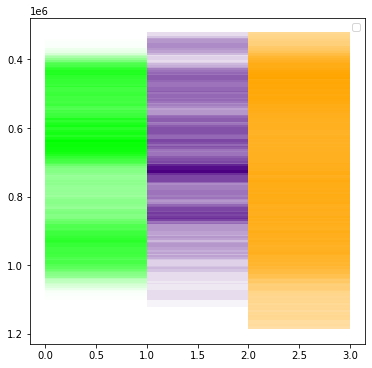

In [113]:
# todo fill with alpha = density
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for i in range(len(bin_centers)):
        bin_start, bin_end = bin_centers[i] - step_size // 2, bin_centers[i] + step_size // 2
        ax.fill_between([0, 1], [bin_start]*2, [bin_end]*2, alpha=exc_soma_densities[i] / max(exc_soma_densities), color="lime", edgecolor=None)
        ax.fill_between([1, 2], [bin_start]*2, [bin_end]*2, alpha=inh_soma_densities[i] / max(inh_soma_densities), color="indigo", edgecolor=None)
        ax.fill_between([2, 3], [bin_start]*2, [bin_end]*2, alpha=avg_volumes[i] / max(avg_volumes), color="orange", edgecolor=None)
    
ax.invert_yaxis()
ax.legend()
plt.show()

53552

## Ideas:
Use synapse_query(bounding_box) to get synapse density too (and stratify by cell type)

Use inhibitory cell subclass densities (do these use depth info? yes, so don't)

Use *excitatory* soma features (they're much less noisy than inhibitory/combined features) and look for significant and steep changes in these features with depth by using the fft-smoothed version of each feature (as a function of depth) and then take its derivative (in fourier domain). The magnitude of the derivative of the smoothed function indicates how much of a transition zone it is according to that feature, and if we take the product of these derivative magnitudes we should see peaks at the layer borders.

In [103]:
soma_features.columns

Index(['index', 'nucleus_area', 'nucleus_area_to_volume',
       'nucleus_center_mass_nm', 'nucleus_fold_area', 'nucleus_fract_fold',
       'nucleus_id', 'nucleus_volume', 'cleft_segid', 'size', 'centroid_x',
       'centroid_y', 'centroid_z', 'yr_um_translated', 'predict',
       'is_watertight', 'soma_center_mass', 'soma_volume', 'soma_area',
       'soma_area_to_volume', 'num_processes', 'avg_sdf', 'orients', 'vectors',
       'n_soma_syn', 'soma_syn_density', 'nuc_id', 'seg_id', 'soma_y',
       'soma_x', 'soma_z', 'xr', 'yr', 'nucleus_to_soma', 'sum_proc_sdf',
       'cell_type_pred_num', 'cell_type_pred', 'umapx', 'umapy', 'visible',
       'outline_color', 'outline_width', 'max_sdf'],
      dtype='object')